In [1]:
!wget https://hf.co/danjacobellis/walloc/resolve/main/v0.8.0.pth

--2024-09-01 15:11:22--  https://hf.co/danjacobellis/walloc/resolve/main/v0.8.0.pth
Resolving hf.co (hf.co)... 44.212.132.255, 3.210.66.237, 34.198.14.237, ...
Connecting to hf.co (hf.co)|44.212.132.255|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://huggingface.co/danjacobellis/walloc/resolve/main/v0.8.0.pth [following]
--2024-09-01 15:11:22--  https://huggingface.co/danjacobellis/walloc/resolve/main/v0.8.0.pth
Resolving huggingface.co (huggingface.co)... 108.156.211.51, 108.156.211.95, 108.156.211.125, ...
Connecting to huggingface.co (huggingface.co)|108.156.211.51|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/f3/ba/f3ba06623731c38247420d7019770a013d176a409abc994df4fee215d214a026/71d52a393ba8e34fcb7d10be77749fb9e2904d886ef2af69a4e2acd942c98b11?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27v0.8.0.pth%3B+filename%3D%22v0.8.0.pth%22%3B&Expires=17

In [2]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from PIL import Image
from IPython.display import display
from torchvision.transforms import ToPILImage, PILToTensor, Resize, CenterCrop, ToTensor
from walloc import walloc
from piq import LPIPS
from fastprogress.fastprogress import progress_bar
class Config: pass

In [4]:
device = "cuda:0"
checkpoint = torch.load("v0.8.0.pth",map_location="cpu",weights_only=False)
codec_config = checkpoint['config']
codec_config.n_bits=5
codec = walloc.Walloc(
    channels = codec_config.channels,
    J = codec_config.J,
    Ne = codec_config.Ne,
    Nd = codec_config.Nd,
    latent_dim = codec_config.latent_dim,
    latent_bits = codec_config.latent_bits
)
codec.load_state_dict(checkpoint['model_state_dict'])
codec = codec.to(device)
codec.eval();

In [5]:
inet1k = load_dataset("imagenet-1k",trust_remote_code=True)

Loading dataset shards:   0%|          | 0/257 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/25 [00:00<?, ?it/s]

In [6]:
lpips_loss = LPIPS().to(device)

/home/dgj335/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dgj335/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
%%time
lanczos = Image.Resampling.LANCZOS
lpips_224 = []
lpips_walloc = []
for i_sample, sample in enumerate(progress_bar(inet1k['validation'])):
    img = sample['image'].convert("RGB")
    img = CenterCrop(min(img.width,img.height))(img)
    img_224 = Resize(img.width)((Resize(224,lanczos)(img)))
    with torch.no_grad():
        x = PILToTensor()(Resize(512)(img)).to(torch.float)
        x = (x/255 - 0.5).unsqueeze(0).to(device)
        x_hat, _, _ = codec(x)
        img_walloc = ToPILImage()(x_hat[0]+0.5)
        img_walloc = Resize(img.width)(img_walloc)
        
        lpips_224.append(lpips_loss(
            ToTensor()(img).unsqueeze(0).to(device),
            ToTensor()(img_224).unsqueeze(0).to(device),
        ).item())
        lpips_walloc.append(lpips_loss(
            ToTensor()(img).unsqueeze(0).to(device),
            ToTensor()(img_walloc).unsqueeze(0).to(device),
        ).item())

CPU times: user 5h 59min 17s, sys: 43 s, total: 6h
Wall time: 26min 9s


In [8]:
np.median([-10*np.log10(d) for d in lpips_224])

/tmp/ipykernel_1294606/4194406233.py:1: RuntimeWarning: divide by zero encountered in log10
  np.median([-10*np.log10(d) for d in lpips_224])


7.927045156357849

In [9]:
np.median([-10*np.log10(d) for d in lpips_walloc])

7.825702455583536

In [10]:
-10*np.log10(lpips_224[-1])

6.705420615857298

In [11]:
-10*np.log10(lpips_walloc[-1])

6.205989180944986

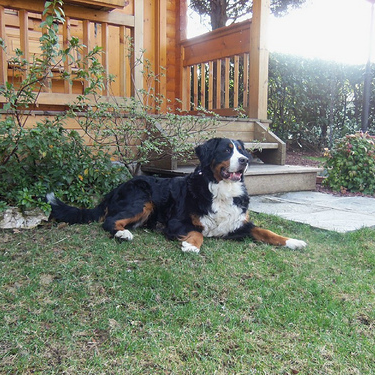

In [12]:
img

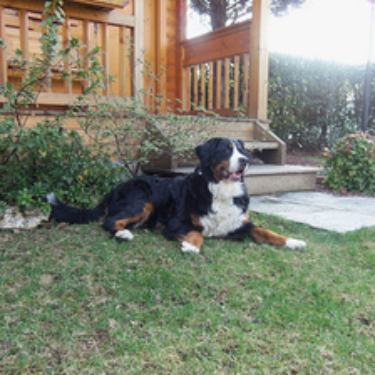

In [13]:
img_224

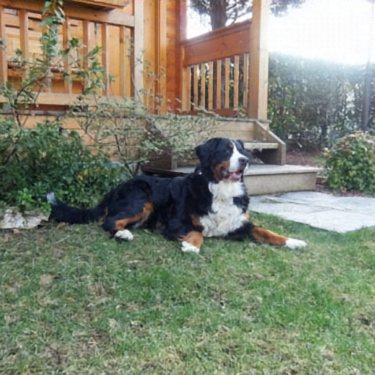

In [14]:
img_walloc